In [2]:
import numpy as np
import json
import albumentations as A
import cv2
import math
from PIL import Image
from imgaug import augmenters as iaa
from torchvision.transforms import functional as F

SEED = 42
cloud_transform = iaa.Sequential(
    [
        iaa.Clouds(seed=SEED),
    ]
)


IMG_SIZE = 10496

class RandomRotate(A.Rotate):
    def __init__(
        self,
        center_coords,
        limit=90,
        interpolation=cv2.INTER_LINEAR,
        border_mode=cv2.BORDER_REFLECT_101,
        value=None,
        mask_value=None,
        method="largest_box",
        crop_border=False,
        always_apply=False,
        p=0.5,
    ):
        super().__init__(
            limit, interpolation, border_mode, value, mask_value, method, crop_border, always_apply, p
        )
        self.center_coords = center_coords

        if method not in ["largest_box", "ellipse"]:
            raise ValueError(f"Rotation method {self.method} is not valid.")

    def apply_to_keypoint(
        self, keypoint, angle=0, x_min=None, x_max=None, y_min=None, y_max=None, cols=IMG_SIZE, rows=IMG_SIZE, **params
    ):
        matrix = cv2.getRotationMatrix2D(self.center_coords, angle, 1.0)
        x, y, a, s = keypoint[:4]
        x, y = cv2.transform(np.array([[[x, y]]]), matrix).squeeze()
        
        return x, y, a + math.radians(angle), s


In [10]:
from torchvision.transforms import autoaugment, transforms

image = cv2.imread(f"../data/train/img/1.png")[..., ::-1]

cloud_transform = iaa.Sequential(
    [
        iaa.Clouds(seed=SEED),
    ]
)
aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.PILToTensor(),
    iaa.Clouds(seed=SEED),
])

aug = transforms.Compose([
    iaa.Sequential([
        iaa.Clouds(seed=SEED),
    ]).augment_image,
    transforms.ToTensor()
])
print(aug[0])

transformed_img = aug(image)

TypeError: 'Compose' object is not subscriptable

Base angle: 90
Transformed angle: 164.49289247907996


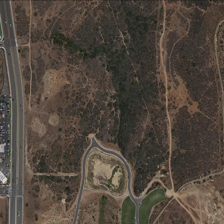

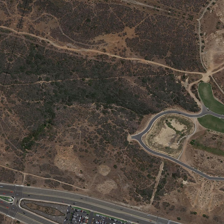

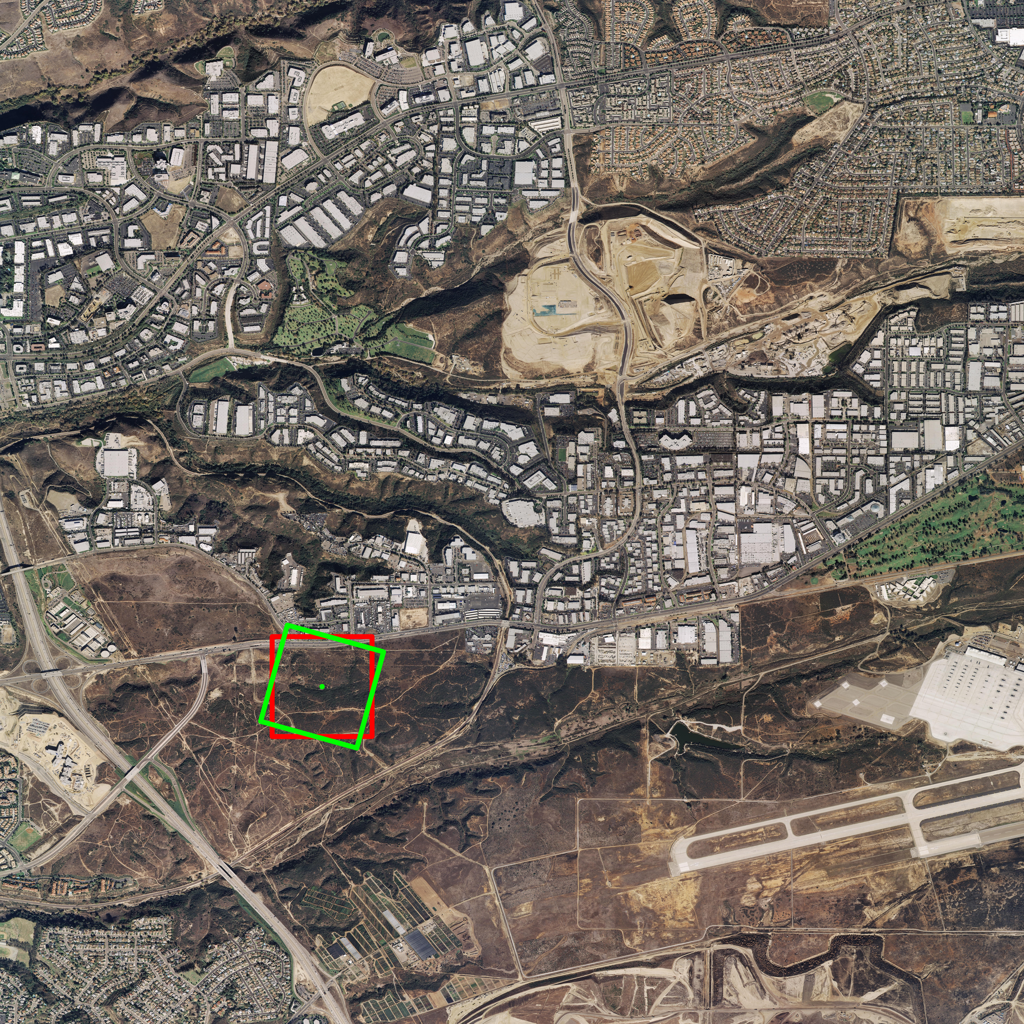

In [77]:
img_id = 34
original_img = cv2.imread(str("../data/original.tiff"))[..., ::-1]
original_img = np.float32(original_img)
image = cv2.imread(f"../data/train/img/{img_id}.png")[..., ::-1]
with open(f"../data/train/json/{img_id}.json", "r") as f:
    meta = json.load(f)
keypoints = [
    coords + [meta["angle"]]
    for key, coords in meta.items() if key != "angle"
]

# real points
points = np.array([
    keypoints[0][:2],
    keypoints[1][:2],
    keypoints[3][:2],
    keypoints[2][:2],
])
angle = keypoints[0][2]
cv2.polylines(original_img, [points], True, color=(255, 0, 0), thickness=50)
center_coords = (points[:, 0].min() + points[:, 0].max()) // 2, (points[:, 1].min() + points[:, 1].max()) // 2
cv2.circle(original_img, center_coords, 2, (255, 0, 0), thickness=50)
print("Base angle:", angle)

# gen points
transform = A.Compose([
    RandomRotate(
        center_coords=np.float32(center_coords), 
        limit=360,
        p=1),
], keypoint_params=A.KeypointParams(format='xya', angle_in_degrees=True, remove_invisible=False, check_each_transform=False))

transformed = transform(image=image, keypoints=keypoints)
points = np.array([
    transformed["keypoints"][0][:2],
    transformed["keypoints"][1][:2],
    transformed["keypoints"][3][:2],
    transformed["keypoints"][2][:2],
])
angle = transformed["keypoints"][0][2]
cv2.polylines(original_img, [points], True, color=(0, 255, 0), thickness=50)
t_center_coords = (points[:, 0].min() + points[:, 0].max()) // 2, (points[:, 1].min() + points[:, 1].max()) // 2
cv2.circle(original_img, t_center_coords, 2, (0, 255, 0), thickness=50)
print("Transformed angle:", angle)


# plot img
display(Image.fromarray(image).resize((224, 224)))
display(Image.fromarray(transformed["image"]).resize((224, 224)))
display(Image.fromarray(np.uint8(original_img)).resize((1024, 1024)))